# Finding a Competent Subset for Visualization, Simulation, or 3D Printing

This notebook contains functions and the workflow for finding a competent subset for visualization.

**Author Contact:** <br>
LinkedIn: [Çınar Turhan](https://www.linkedin.com/in/cinarturhan/) <br>
Email: [cinarturhan@utexas.edu](mailto:cinarturhan@utexas.edu)


## Table of Contents
[1. Finding a Competent Subset](#chapter1)<br>
[1.1 Required Modules](#section_1_1)<br>
[1.2. Functions](#section_1_2)<br>
[1.3. Loading the Data](#section_1_3)<br>
[1.4. Initial Visualizations](#section_1_4)<br>
[1.5. Finding the Competent Subsets](#section_1_5)<br>
[1.6. Final Visualizations](#section_1_5)<br>
[2. Comparison Between the Layered, and Non-Layered Edges for a Subset](#chapter2)<br>
___

# 1. Finding a Competent Subset <a class="anchor" id="chapter1"></a>

## 1.1. Required Modules <a class="anchor" id="section_1_1"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import pyvista as pv
pv.set_jupyter_backend('server')
import cc3d
import tifffile

import warnings
warnings.filterwarnings('ignore')

from copy import deepcopy
import glob
import scipy
import os

## Functions <a class="anchor" id="section_1_2"></a>

1. **find_porosity_visualization_subset**: Finds the competent visualization subset.
2. **add_layer**: Adds a layer of pores or solids around the sample to distinguish the pores in visualization, create solid boundaries for simulation, or prepare a model for 3D printing.
3. **invert_image**: Inverts pore and solid classes in  a sample.
4. **plot_sample**: Visualizing the samples.

In [2]:
def find_porosity_visualization_subset(data, cube_size = 100, batch=100, pore_class = 0):
    '''
    Finds the best cubic subset for visaulizing the segmented dataset.
    
    data: 3D numpy array, vector class from DPM Tools, Image class from DPM Tools.
    cube_size: Size of the visalization cube, default is 100 (100x100x100). 
    batch: Batch over which to calculate the stats, default is 100.
    
    '''
    
    if str(type(data))=="<class 'dpm_tools.io.read_data.Vector'>":
        scalar_data = deepcopy(data.image)
    elif str(type(data))=="<class 'dpm_tools.io.read_data.Image'>":
        scalar_data = deepcopy(data)
    else:
        scalar_data = deepcopy(data)

    if pore_class != 1:
        scalar_data[scalar_data==pore_class]=199
        scalar_data[scalar_data!=199]=pore_class
        scalar_data[scalar_data==199]=1

    size = scalar_data.shape[0]*scalar_data.shape[1]*scalar_data.shape[2]
    porosity = (scalar_data==1).sum()/size

    sample_size = cube_size

    # Inner cube increment
    inc = sample_size-int(sample_size*0.5)

    # One dimension of the given vector sample cube.
    max_dim = len(scalar_data)    

    batch_for_stats = max_dim-sample_size # Max possible batch number

    # Or overwrite:
    batch_for_stats = batch

    stats_array=np.zeros(shape=(5,batch_for_stats))

    i=0
    while i<batch_for_stats:
        mini = np.random.randint(low=0, high=max_dim-sample_size)
        maxi = mini+sample_size

        scalar_boot = scalar_data[mini:maxi,mini:maxi,mini:maxi]
        scalar_boot_inner = scalar_data[mini+inc:maxi-inc,mini+inc:maxi-inc,mini+inc:maxi-inc]

        labels_out_outside, N = cc3d.largest_k(
            scalar_boot, k=1, 
            connectivity=26, delta=0,
            return_N=True,
        )

        index_outside,counts_outside = np.unique(labels_out_outside,return_counts=True)
        counts_outside_sum = np.sum(counts_outside[1:])

        labels_out_inside, N = cc3d.largest_k(
            scalar_boot_inner, k=1, 
            connectivity=26, delta=0,
            return_N=True,
        )

        index_inside,counts_inside = np.unique(labels_out_inside,return_counts=True)
        counts_inside_sum = np.sum(counts_inside[1:])

        porosity_selected = (scalar_boot==1).sum()/sample_size**3

        if (porosity_selected<=porosity*1.2)&(porosity_selected>=porosity*0.8):
            stats_array[0,i] = counts_outside_sum
            stats_array[1,i] = counts_inside_sum     
            stats_array[2,i] = porosity_selected   
            stats_array[3,i] = mini
            stats_array[4,i] = scipy.stats.hmean([stats_array[0,i],
                                                  stats_array[1,i]])
            i+=1

        else:
            continue


    best_index = np.argmax(stats_array[4,:])
    best_subset_range = int(stats_array[3,best_index])

    print(f'Original Porosity: {round(porosity*100,2)} %\n' +
          f'Subset Porosity: {round(stats_array[2,best_index]*100,2)} %\n' +
          f'Competent Subset: [{best_subset_range}:{best_subset_range+cube_size},' +
          f'{best_subset_range}:{best_subset_range+cube_size},{best_subset_range}:{best_subset_range+cube_size}]')
    
    best_subset_range = (int(best_subset_range),int(best_subset_range+cube_size))
    
    return best_subset_range, stats_array

def add_layer(scalar_data, subset_range, trim_pixels_from_sides = 4, insert_phase = 'pore', pore_class = 0, solid_class = 1):
    '''
    Takes the whole data, and the subset_range that is to be visualized. Trims the pixels from the sides,
    based on the keyword trim_pixels_from_each_sides. Replaces those with pore or solid phase based on insert_phase keyword.
    By default, pore_class is 0, and the solid_class is 1. If you have different values, set those keywords to those numbers.
    scalar_data = 3D numpy array.
    subset_range = Range of interest/Volume of interest.
    trim_pixels_from_each_sides = Thickness of the layer to be added.
    insert_phase = 'solid' or 'pore'. Phase to be inserted.
    pore_class = Value of the pores in the dataset.
    solid_class = Value of the solids in the dataset.
    '''
    mini = subset_range[0]
    maxi = subset_range[1]
    
    scalar_data = deepcopy(scalar_data)
    
    if insert_phase == 'pore':
        scalar_data[mini:mini + trim_pixels_from_sides, :, :] = pore_class
        scalar_data[:, mini:mini + trim_pixels_from_sides, :] = pore_class
        scalar_data[:, :, mini:mini + trim_pixels_from_sides] = pore_class
        scalar_data[maxi - trim_pixels_from_sides:maxi, :, :] = pore_class
        scalar_data[:, maxi - trim_pixels_from_sides:maxi, :] = pore_class
        scalar_data[:, :, maxi - trim_pixels_from_sides:maxi] = pore_class
    elif insert_phase == 'solid':
        scalar_data[mini:mini + trim_pixels_from_sides, :, :] = solid_class
        scalar_data[:, mini:mini + trim_pixels_from_sides, :] = solid_class
        scalar_data[:, :, mini:mini + trim_pixels_from_sides] = solid_class
        scalar_data[maxi - trim_pixels_from_sides:maxi, :, :] = solid_class
        scalar_data[:, maxi - trim_pixels_from_sides:maxi, :] = solid_class
        scalar_data[:, :, maxi - trim_pixels_from_sides:maxi] = solid_class
    else:
        raise Exception('Please enter a valid class: \'solid\' or \'pore\' only')
    
    sample = scalar_data[mini:maxi,mini:maxi,mini:maxi]
        
    return sample



def invert_image(scalar_data,pore_class=0,solid_class=1):
    '''
    Converts the pore class to solid class and vice versa. Eg, if the pores are set to 0 and the matrix is set to 1, the function inverts them
    and the resulting values for pores become 1, and the matrix becomes 0.

    pore_class = Value of the pores in the dataset.
    solid_class = Value of the solids in the dataset.
    
    '''
    scalar_data[scalar_data==class_1]=199
    scalar_data[scalar_data!=199]=class_1
    scalar_data[scalar_data==199]=class_2
    return scalar_data

def plot_sample(sample, subset=True, subset_range = (0,128)):
    '''
    Plots the isosurfaces between pores and solids. 
    subset: If true, assign the subset_range you want to plot. If false, it plots the whole sample.
    subset_range: If subset is set to 'True', assign the range here.
    '''
    plotter_obj = pv.Plotter(lighting='three lights')#notebook=True, off_screen=False, lighting='three lights')

    # Set background colors
    plotter_obj.set_background(color='w')
#     plotter_obj.add_light(pv.Light(light_type='headlight'))

    # Set font colors and sizes
    pv.global_theme.font.color = 'black'
    pv.global_theme.font.size = 18
    pv.global_theme.font.label_size = 14
    
    pv.set_jupyter_backend('server')

    mini = subset_range[0]
    maxi = subset_range[1]
    
    if subset:
        sample = sample[mini:maxi,mini:maxi,mini:maxi]
    
    pv_image_obj = pv.wrap(sample)
    contours = pv_image_obj.contour(isosurfaces=[0.5])
    plotter_obj.add_mesh(contours, opacity=1, color=(200 / 255, 181 / 255, 152 / 255), diffuse=0.75, ambient=0.15)
    
    
    plotter_obj.show(jupyter_backend='server')

## Loading the Data <a class="anchor" id="section_1_3"></a>

In these datasets, pores are set to 1, and the solids are set to 0.

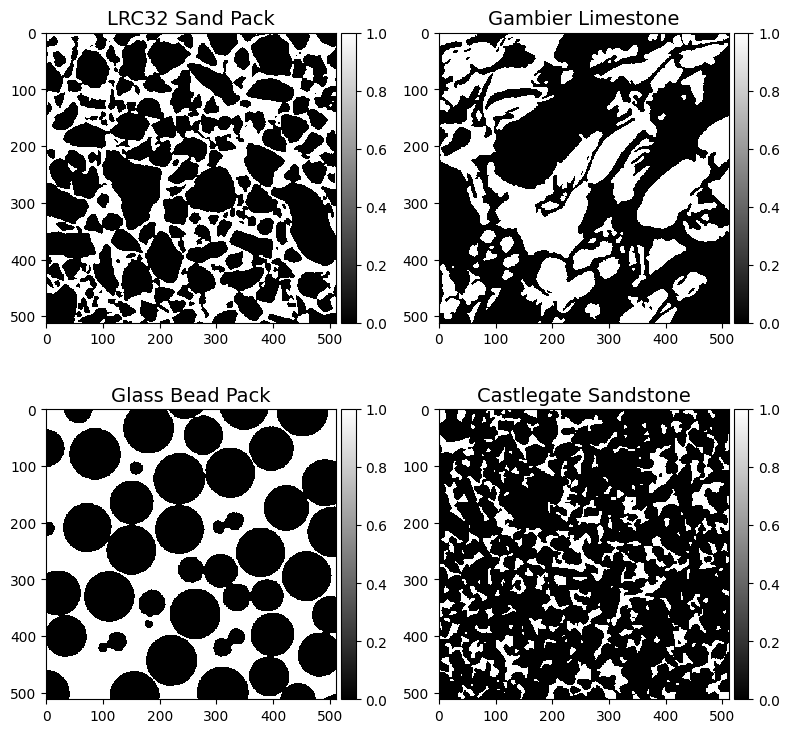

In [3]:
img_list = glob.glob('../data/*.tif')
segmented_bead_pack_512, segmented_castle_512, segmented_Gambier, segmented_lrc32 = [tifffile.imread(tif_img) for tif_img in img_list]

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(8,8))
ax = ax.flatten()

skimage.io.imshow(segmented_lrc32[0,:,:], cmap='gray', ax=ax[0])
ax[0].set_title('LRC32 Sand Pack',fontsize=14)

skimage.io.imshow(segmented_Gambier[0,:,:], cmap='gray', ax=ax[1])
ax[1].set_title('Gambier Limestone',fontsize=14)

skimage.io.imshow(segmented_bead_pack_512[0,:,:], cmap='gray', ax=ax[2])
ax[2].set_title('Glass Bead Pack',fontsize=14)

skimage.io.imshow(segmented_castle_512[0,:,:], cmap='gray', ax=ax[3])
ax[3].set_title('Castlegate Sandstone',fontsize=14)

plt.show()

## Initial Visualizations <a class="anchor" id="section_1_4"></a>

In [4]:
# subset_range = (128,256)
segmented_lrc32_vis = add_layer(segmented_lrc32, subset_range = (128,256), trim_pixels_from_sides = 10, insert_phase = 'pore', pore_class = 1, solid_class = 0)
segmented_Gambier_vis = add_layer(segmented_Gambier, subset_range = (128,256), trim_pixels_from_sides = 10, insert_phase = 'pore', pore_class = 1, solid_class = 0)
segmented_bead_pack_512_vis = add_layer(segmented_bead_pack_512, subset_range = (128,256), trim_pixels_from_sides = 10, insert_phase = 'pore', pore_class = 1, solid_class = 0)
segmented_castle_512_vis = add_layer(segmented_castle_512, subset_range = (128,256), trim_pixels_from_sides = 10, insert_phase = 'pore', pore_class = 1, solid_class = 0)

plot_sample(segmented_lrc32_vis, subset=False, subset_range = (0,128))
plot_sample(segmented_Gambier_vis, subset=False, subset_range = (0,128))
plot_sample(segmented_bead_pack_512_vis, subset=False, subset_range = (0,128))
plot_sample(segmented_castle_512_vis, subset=False, subset_range = (0,128))

Widget(value='<iframe src="http://localhost:62205/index.html?ui=P_0x18d95e61210_0&reconnect=auto" class="pyvis…

Widget(value='<iframe src="http://localhost:62205/index.html?ui=P_0x18dd924c6d0_1&reconnect=auto" class="pyvis…

Widget(value='<iframe src="http://localhost:62205/index.html?ui=P_0x18deaef34d0_2&reconnect=auto" class="pyvis…

Widget(value='<iframe src="http://localhost:62205/index.html?ui=P_0x18dd923f2d0_3&reconnect=auto" class="pyvis…

In [5]:
# Porosity of the selected subset of Gambier Limestone
segmented_Gambier_Subset_128 = segmented_Gambier[128:256, 128:256, 128:256]
porosity = np.sum(segmented_Gambier_Subset_128 == 1)/(128**3)*100
print(round(porosity, 1), '%')

71.6 %


## Finding the Competent Subsets <a class="anchor" id="section_1_4"></a>

In [6]:
subset1, _ = find_porosity_visualization_subset(segmented_lrc32, cube_size=128, batch=100, pore_class = 1)

Original Porosity: 36.32 %
Subset Porosity: 36.59 %
Competent Subset: [138:266,138:266,138:266]


In [11]:
subset2, _ = find_porosity_visualization_subset(segmented_Gambier, cube_size=128, batch=100, pore_class = 1)

Original Porosity: 43.59 %
Subset Porosity: 42.85 %
Competent Subset: [27:155,27:155,27:155]


In [8]:
subset3, _ = find_porosity_visualization_subset(segmented_bead_pack_512, cube_size=128, batch=100, pore_class = 1)

Original Porosity: 37.88 %
Subset Porosity: 32.85 %
Competent Subset: [106:234,106:234,106:234]


In [9]:
subset4, _ = find_porosity_visualization_subset(segmented_castle_512, cube_size=128, batch=100, pore_class = 1)

Original Porosity: 20.61 %
Subset Porosity: 20.94 %
Competent Subset: [123:251,123:251,123:251]


## Final Visualizations <a class="anchor" id="section_1_5"></a>

In [12]:
segmented_lrc32_vis = add_layer(segmented_lrc32, subset_range = subset1, trim_pixels_from_sides = 2, insert_phase = 'pore', pore_class = 1, solid_class = 0)
segmented_Gambier_vis = add_layer(segmented_Gambier, subset_range = subset2, trim_pixels_from_sides = 2, insert_phase = 'pore', pore_class = 1, solid_class = 0)
segmented_bead_pack_512_vis = add_layer(segmented_bead_pack_512, subset_range = subset3, trim_pixels_from_sides = 2, insert_phase = 'pore', pore_class = 1, solid_class = 0)
segmented_castle_512_vis = add_layer(segmented_castle_512, subset_range = subset4, trim_pixels_from_sides = 2, insert_phase = 'pore', pore_class = 1, solid_class = 0)

plot_sample(segmented_lrc32_vis, subset=False)
plot_sample(segmented_Gambier_vis, subset=False)
plot_sample(segmented_bead_pack_512_vis, subset=False)
plot_sample(segmented_castle_512_vis, subset=False)

Widget(value='<iframe src="http://localhost:62205/index.html?ui=P_0x18e24c1b110_8&reconnect=auto" class="pyvis…

Widget(value='<iframe src="http://localhost:62205/index.html?ui=P_0x18e253c17d0_9&reconnect=auto" class="pyvis…

Widget(value='<iframe src="http://localhost:62205/index.html?ui=P_0x18e253818d0_10&reconnect=auto" class="pyvi…

Widget(value='<iframe src="http://localhost:62205/index.html?ui=P_0x18e24974110_11&reconnect=auto" class="pyvi…

## Comparison Between the Layered, and Non-Layered Edges for a Subset <a class="anchor" id="chapter2"></a>

In [15]:
segmented_Gambier_vis = add_layer(segmented_Gambier, subset_range = subset2, 
                                  trim_pixels_from_sides = 2, 
                                  insert_phase = 'pore', 
                                  pore_class = 1, 
                                  solid_class = 0)

plot_sample(segmented_Gambier_vis,subset=False)
plot_sample(segmented_Gambier,subset=True, subset_range=subset2)

Widget(value='<iframe src="http://localhost:62205/index.html?ui=P_0x18e249ee5d0_16&reconnect=auto" class="pyvi…

Widget(value='<iframe src="http://localhost:62205/index.html?ui=P_0x18e249cf110_17&reconnect=auto" class="pyvi…

____

Author: [Çınar Turhan](https://www.linkedin.com/in/cinarturhan/)